# Neuronale Netze


Links:
https://www.h2kinfosys.com/blog/linear-regression-with-keras-on-tensorflow/

Papers:

Neural network powered COVID-19 spread forecasting model
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7428770/

Scaling regression inputs by dividing by two standard deviations
http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf

In [1]:
import io
import urllib
import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from progressbar import ProgressBar
import time

from datetime import datetime

In [2]:
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing


In [3]:
data_all = pd.read_csv("data_all.csv")
data_all["Meldedatum"] = pd.to_datetime(data_all["Meldedatum"]) #- pd.to_timedelta(7, unit='d')
data_all

,IdLandkreis,Meldedatum,AnzahlFall,AnzahlGenesen,AnzahlFall>59,Landkreis,Bevölkerung gesamt,Ü65%,Ausländer%,Bevölkerungsdichte EW/km²,...,1to5friends,churchTW,churchGANZ,personen_erst_kumulativ,personen_voll_kumulativ,7dInzidenzFUTURE,AnzahlFallFUTURE,BgastP,BgesundP,Gsaison
0,8111,2020-03-07,5,5,0,SK Stuttgart,645315,0.176218,0.249539,3067,...,0,0,0,0.000000,0.000000,12.087120,78,0.018617,0.074313,1
1,8111,2020-03-14,78,78,3,SK Stuttgart,645315,0.176218,0.249539,3067,...,0,0,0,0.000000,0.000000,48.038555,310,0.018617,0.074313,1
2,8111,2020-03-21,310,303,41,SK Stuttgart,645315,0.176218,0.249539,3067,...,1,0,1,0.000000,0.000000,42.614847,275,0.018617,0.074313,1
3,8111,2020-03-28,275,261,65,SK Stuttgart,645315,0.176218,0.249539,3067,...,1,0,1,0.000000,0.000000,36.726250,237,0.018617,0.074313,1
4,8111,2020-04-04,237,225,65,SK Stuttgart,645315,0.176218,0.249539,3067,...,1,0,1,0.000000,0.000000,23.864314,154,0.018617,0.074313,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,8437,2021-02-20,40,40,11,LK Sigmaringen,131950,0.212952,0.113027,109,...,1,1,0,0.038975,0.020910,60.629026,80,0.008230,0.055817,1
2296,8437,2021-02-27,80,79,14,LK Sigmaringen,131950,0.212952,0.113027,109,...,1,1,0,0.048003,0.025293,81.849185,108,0.008230,0.055817,1
2297,8437,2021-03-06,108,106,19,LK Sigmaringen,131950,0.212952,0.113027,109,...,1,1,0,0.061021,0.029720,122.015915,161,0.008230,0.055817,1
2298,8437,2021-03-13,161,158,22,LK Sigmaringen,131950,0.212952,0.113027,109,...,1,1,0,0.077312,0.034345,162.182645,214,0.008230,0.055817,1


In [4]:
data_all.isna().sum()

IdLandkreis                  0
Meldedatum                   0
AnzahlFall                   0
AnzahlGenesen                0
AnzahlFall>59                0
Landkreis                    0
Bevölkerung gesamt           0
Ü65%                         0
Ausländer%                   0
Bevölkerungsdichte EW/km²    0
Temperatur                   0
BIPK                         0
Bgast                        0
Bgesund                      0
afd21                        0
GoogleCorona                 0
GoogleUrlaub                 0
7dInzidenz                   0
7dInzidenzFall>59            0
AnzahlFall>59%               0
AnzahlGenesenLandkreis       0
AnzahlGenesenLandkreis%      0
leavehome                    0
dist                         0
trvl                         0
gastr                        0
mskÖPVN                      0
mskÖFF                       0
shppngTW                     0
shppngGANZ                   0
hcutTW                       0
hcutGANZ                     0
ess_shps

In [5]:
data_all.dtypes

IdLandkreis                           int64
Meldedatum                   datetime64[ns]
AnzahlFall                            int64
AnzahlGenesen                         int64
AnzahlFall>59                         int64
Landkreis                            object
Bevölkerung gesamt                    int64
Ü65%                                float64
Ausländer%                          float64
Bevölkerungsdichte EW/km²             int64
Temperatur                          float64
BIPK                                float64
Bgast                                 int64
Bgesund                               int64
afd21                               float64
GoogleCorona                          int64
GoogleUrlaub                          int64
7dInzidenz                          float64
7dInzidenzFall>59                   float64
AnzahlFall>59%                      float64
AnzahlGenesenLandkreis                int64
AnzahlGenesenLandkreis%             float64
leavehome                       

In [6]:
# data_y = data_all[["IdLandkreis", "Meldedatum", "7dInzidenz", "AnzahlFall"]].copy()
# data_y.Meldedatum = data_y.Meldedatum - pd.to_timedelta(7, unit='d')
# data_y = data_y.rename(columns={"7dInzidenz": "7dInzidenzFUTURE", "AnzahlFall": "AnzahlFallFUTURE" })

In [7]:
# data_all = pd.merge(data_all, data_y, how="inner", on=["IdLandkreis", "Meldedatum"])
# data_all.head
# #data_all.isna().sum()

# Modell Nr. 1

<br>

Einfache Voraussage über features

<br>

In [8]:
data_cutF = data_all[["IdLandkreis","Meldedatum","AnzahlFall","Ü65%","Ausländer%","Bevölkerungsdichte EW/km²","Temperatur","BIPK","Bgast","Bgesund",\
                     "afd21","GoogleCorona","GoogleUrlaub","AnzahlFall>59", "AnzahlGenesenLandkreis%",\
                     "leavehome","dist","trvl","gastr","mskÖPVN","mskÖFF","shppngTW","shppngGANZ","hcutTW","hcutGANZ","ess_shpsTW",\
                     "schoolTW","daycareTW","1to5friends","churchTW","churchGANZ","personen_erst_kumulativ","personen_voll_kumulativ",\
                     "Gsaison", "AnzahlFallFUTURE"]]

# Datensatz für Inzidenz-Vorhersagen
data_cutI = data_all[["IdLandkreis","Meldedatum","7dInzidenz","Ü65%","Ausländer%","Bevölkerungsdichte EW/km²","Temperatur","BIPK","BgastP","BgesundP",\
                     "afd21","GoogleCorona","GoogleUrlaub","7dInzidenzFall>59", "AnzahlGenesenLandkreis%",\
                     "leavehome","dist","trvl","gastr","mskÖPVN","mskÖFF","shppngTW","shppngGANZ","hcutTW","hcutGANZ","ess_shpsTW",\
                     "schoolTW","daycareTW","1to5friends","churchTW","churchGANZ","personen_erst_kumulativ","personen_voll_kumulativ",\
                     "Gsaison", "7dInzidenzFUTURE"]]

train_dataset = data_cutI.groupby("IdLandkreis").sample(frac=0.8, random_state=0)\
                            .sort_values(['IdLandkreis', 'Meldedatum'])
test_dataset = data_cutI.drop(train_dataset.index)

train_dataset = train_dataset.drop(['IdLandkreis', 'Meldedatum'], axis=1)
test_dataset = test_dataset.drop(['IdLandkreis', 'Meldedatum'], axis=1)

#test_dataset
train_dataset

,7dInzidenz,Ü65%,Ausländer%,Bevölkerungsdichte EW/km²,Temperatur,BIPK,BgastP,BgesundP,afd21,GoogleCorona,...,ess_shpsTW,schoolTW,daycareTW,1to5friends,churchTW,churchGANZ,personen_erst_kumulativ,personen_voll_kumulativ,Gsaison,7dInzidenzFUTURE
1,12.087120,0.176218,0.249539,3067,7.49,88.900769,0.018617,0.074313,12.775,100,...,0,0,0,0,0,0,0.000000,0.000000,1,48.038555
2,48.038555,0.176218,0.249539,3067,7.49,88.900769,0.018617,0.074313,12.775,74,...,1,1,1,1,0,1,0.000000,0.000000,1,42.614847
4,36.726250,0.176218,0.249539,3067,13.72,88.900769,0.018617,0.074313,12.775,46,...,1,1,1,1,0,1,0.000000,0.000000,1,23.864314
5,23.864314,0.176218,0.249539,3067,13.72,88.900769,0.018617,0.074313,12.775,49,...,1,1,1,1,0,1,0.000000,0.000000,1,21.694831
6,21.694831,0.176218,0.249539,3067,13.72,88.900769,0.018617,0.074313,12.775,38,...,1,1,1,1,0,1,0.000000,0.000000,1,12.706973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,70.481243,0.212952,0.113027,109,5.21,37.953770,0.008230,0.055817,6.773,33,...,0,1,1,1,1,0,0.027283,0.011987,1,33.345964
2295,30.314513,0.212952,0.113027,109,5.21,37.953770,0.008230,0.055817,6.773,29,...,0,1,1,1,1,0,0.038975,0.020910,1,60.629026
2296,60.629026,0.212952,0.113027,109,5.21,37.953770,0.008230,0.055817,6.773,38,...,0,1,1,1,1,0,0.048003,0.025293,1,81.849185
2298,122.015915,0.212952,0.113027,109,6.73,37.953770,0.008230,0.055817,6.773,36,...,0,1,1,1,1,0,0.077312,0.034345,1,162.182645


In [9]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('7dInzidenzFUTURE')
test_labels = test_features.pop('7dInzidenzFUTURE')

#train_features.head
train_labels

1        48.038555
2        42.614847
4        23.864314
5        21.694831
6        12.706973
           ...    
2293     33.345964
2295     60.629026
2296     81.849185
2298    162.182645
2299    247.821144
Name: 7dInzidenzFUTURE, Length: 1840, dtype: float64

In [10]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[ 58.652   0.208   0.158 561.523  11.496  44.448   0.012   0.057  10.957
  35.33   42.933  14.036   0.01    0.173   0.945   0.966   0.588   0.22
   0.632   0.174   0.249   0.327   0.209   0.093   0.621   0.345   0.966
   0.771   0.195   0.008   0.004   0.629]


In [11]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[  12.09    0.18    0.25 3067.      7.49   88.9     0.02    0.07   12.78
   100.     42.      0.46    0.      0.      0.      0.      0.      0.
     0.      0.      0.      0.      0.      0.      0.      0.      0.
     0.      0.      0.      0.      1.  ]]

Normalized: [[-0.72 -1.79  2.2   3.97 -0.64  3.44  1.13  0.67  0.33  4.29 -0.04 -0.76
  -0.99 -0.46 -4.15 -5.36 -1.19 -0.53 -1.31 -0.46 -0.58 -0.7  -0.51 -0.32
  -1.28 -0.73 -5.36 -1.84 -0.49 -0.43 -0.39  0.77]]


In [12]:
# train_featuresPlot = train_features.melt(var_name='Column', value_name='Not Normalized')
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Not Normalized', data=train_featuresPlot)
# _ = ax.set_xticklabels(train_featuresPlot.keys(), rotation=90)

## Einfaches sequentielles Netz -> 7TageInzidenz

In [13]:
linear_model = tf.keras.Sequential([
    #normalizer,
    layers.Dense(units=1)
])

In [14]:
linear_model.predict(train_features)

array([[499.205],
       [514.229],
       [512.46 ],
       ...,
       [  3.804],
       [ 14.093],
       [ 22.546]], dtype=float32)

In [15]:
keras.backend.set_value(linear_model.layers[0].weights[0][0], [1.0])
linear_model.layers[0].kernel

<tf.Variable 'dense/kernel:0' shape=(32, 1) dtype=float32, numpy=
array([[ 1.   ],
       [-0.075],
       [-0.087],
       [ 0.179],
       [-0.127],
       [-0.288],
       [ 0.21 ],
       [ 0.089],
       [ 0.047],
       [-0.087],
       [-0.426],
       [-0.361],
       [-0.082],
       [ 0.114],
       [-0.287],
       [-0.127],
       [ 0.409],
       [ 0.02 ],
       [-0.041],
       [ 0.341],
       [-0.307],
       [-0.003],
       [ 0.366],
       [-0.263],
       [-0.061],
       [-0.097],
       [ 0.266],
       [ 0.129],
       [-0.108],
       [-0.319],
       [-0.115],
       [-0.191]], dtype=float32)>

In [16]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mean_absolute_error')

Mean Squared Error (MSE) and Mean Absolute Error (MAE) are common loss functions used for regression problems. Mean Absolute Error is less sensitive to outliers. Different loss functions are used for classification problems.

In [17]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=200,
    #batch_size=500,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Wall time: 25.1 s


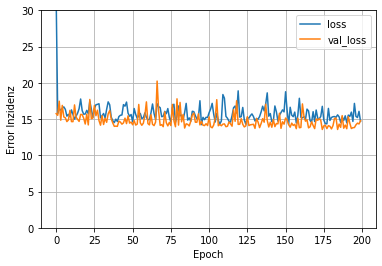

In [18]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 30])
  plt.xlabel('Epoch')
  plt.ylabel('Error Inzidenz')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [19]:
linear_model.layers[0].kernel

<tf.Variable 'dense/kernel:0' shape=(32, 1) dtype=float32, numpy=
array([[  1.014],
       [ -9.105],
       [ -4.178],
       [ -0.011],
       [ -1.556],
       [ -0.05 ],
       [-19.218],
       [-15.534],
       [ -0.018],
       [  0.439],
       [  0.074],
       [ -0.481],
       [  0.298],
       [-16.956],
       [  1.374],
       [  6.807],
       [ -8.36 ],
       [  5.754],
       [  9.51 ],
       [  2.1  ],
       [ -7.823],
       [  5.921],
       [  0.089],
       [  9.952],
       [  1.211],
       [ -6.225],
       [  7.2  ],
       [  7.731],
       [  1.869],
       [ 25.945],
       [ 31.808],
       [  6.207]], dtype=float32)>

In [20]:
test_results = {}

test_results['linear_model'] = linear_model.evaluate(
                                    test_features, test_labels, verbose=0)
test_results

{'linear_model': 15.117589950561523}

Wall time: 24.8 s


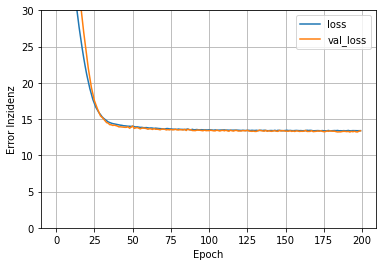

In [21]:
%%time

linear_model_normalized = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model_normalized.predict(train_features)

keras.backend.set_value(linear_model_normalized.layers[1].weights[0][0], [1.0])

linear_model_normalized.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mean_absolute_error')

history_normalized = linear_model_normalized.fit(
    train_features, train_labels, 
    epochs=200,
    #batch_size=500,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

plot_loss(history_normalized)

In [22]:
test_results['linear_model_normalized'] = linear_model_normalized.evaluate(
                                    test_features, test_labels, verbose=0)
test_results

{'linear_model': 15.117589950561523,
 'linear_model_normalized': 12.773072242736816}

## DNN Modell -> 7 Tage Inzidenz

In [23]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [24]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 32)                65        
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 6,402
Trainable params: 6,337
Non-trainable params: 65
_________________________________________________________________


In [25]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 13.2 s


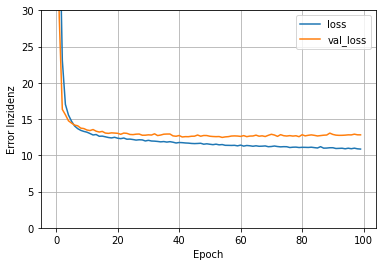

In [26]:
plot_loss(history)

In [27]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [28]:
pd.DataFrame(test_results, index=['Mean absolute error [7TageInzidenzFUTURE]']).T

,Mean absolute error [7TageInzidenzFUTURE]
linear_model,15.117590
linear_model_normalized,12.773072
dnn_model,11.564630


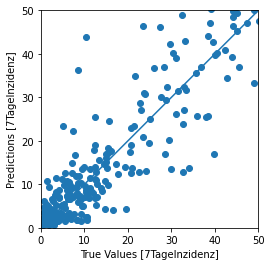

In [29]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [7TageInzidenz]')
plt.ylabel('Predictions [7TageInzidenz]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

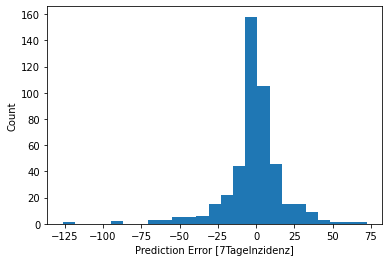

In [30]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [7TageInzidenz]')
_ = plt.ylabel('Count')

## DNN -> Fallzahlen

In [31]:
train_datasetF = data_cutF.groupby("IdLandkreis").sample(frac=0.8, random_state=0)\
                            .sort_values(['IdLandkreis', 'Meldedatum'])
test_datasetF = data_cutF.drop(train_dataset.index)

train_datasetF = train_datasetF.drop(['IdLandkreis', 'Meldedatum'], axis=1)
test_datasetF = test_datasetF.drop(['IdLandkreis', 'Meldedatum'], axis=1)

In [32]:
train_featuresF = train_datasetF.copy()
test_featuresF = test_datasetF.copy()

train_labelsF = train_featuresF.pop('AnzahlFallFUTURE')
test_labelsF = test_featuresF.pop('AnzahlFallFUTURE')

#train_features.head
train_labelsF

1       310
2       275
4       154
5       140
6        82
       ... 
2293     44
2295     80
2296    108
2298    214
2299    327
Name: AnzahlFallFUTURE, Length: 1840, dtype: int64

In [33]:
normalizerF = preprocessing.Normalization()
normalizerF.adapt(np.array(train_featuresF))
print(normalizerF.mean.numpy())

[  147.368     0.208     0.158   561.523    11.496    44.448  2932.511
 14088.516    10.957    35.33     42.933    34.735     0.01      0.173
     0.945     0.966     0.588     0.22      0.632     0.174     0.249
     0.327     0.209     0.093     0.621     0.345     0.966     0.771
     0.195     0.008     0.004     0.629]


In [34]:
firstF = np.array(train_featuresF[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', firstF)
  print()
  print('Normalized:', normalizerF(firstF).numpy())

First example: [[   78.       0.18     0.25  3067.       7.49    88.9  12014.   47955.
     12.78   100.      42.       3.       0.       0.       0.       0.
      0.       0.       0.       0.       0.       0.       0.       0.
      0.       0.       0.       0.       0.       0.       0.       1.  ]]

Normalized: [[-0.36 -1.79  2.2   3.97 -0.64  3.44  4.47  3.96  0.33  4.29 -0.04 -0.64
  -0.99 -0.46 -4.15 -5.36 -1.19 -0.53 -1.31 -0.46 -0.58 -0.7  -0.51 -0.32
  -1.28 -0.73 -5.36 -1.84 -0.49 -0.43 -0.39  0.77]]


In [35]:
dnn_modelF = build_and_compile_model(normalizerF)
dnn_modelF.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 32)                65        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 6,402
Trainable params: 6,337
Non-trainable params: 65
_________________________________________________________________


In [36]:
%%time
historyF = dnn_modelF.fit(
    train_featuresF, train_labelsF,
    validation_split=0.2,
    verbose=0, epochs=250)

Wall time: 35.5 s


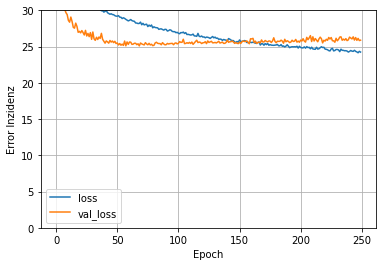

In [37]:
plot_loss(historyF)

In [38]:
test_resultsF = {}

test_resultsF['dnn_modelF'] = dnn_modelF.evaluate(test_featuresF, test_labelsF, verbose=0)
print(test_resultsF)

{'dnn_modelF': 28.029277801513672}


## DNN Modell -> 7 Tage Inzidenz

In [39]:
def build_and_compile_BIGmodel(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [40]:
dnn_BIGmodel = build_and_compile_BIGmodel(normalizer)
dnn_BIGmodel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 32)                65        
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 18,818
Trainable params: 18,753
Non-trainable params: 65
_________________________________________________________________


In [41]:
%%time
history = dnn_BIGmodel.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 16 s


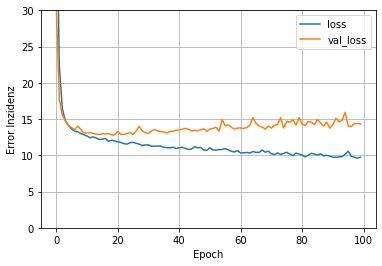

In [42]:
plot_loss(history)

In [43]:
test_results['dnn_BIGmodel'] = dnn_BIGmodel.evaluate(test_features, test_labels, verbose=0)

In [44]:
pd.DataFrame(test_results, index=['Mean absolute error [7TageInzidenzFUTURE]']).T

,Mean absolute error [7TageInzidenzFUTURE]
linear_model,15.117590
linear_model_normalized,12.773072
dnn_model,11.564630
dnn_BIGmodel,12.548034


In [45]:
def build_and_compile_MEDmodel(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(1, activation='linear')
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [46]:
dnn_MEDmodel = build_and_compile_MEDmodel(normalizer)
dnn_MEDmodel.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 32)                65        
_________________________________________________________________
dense_12 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 8,450
Trainable params: 8,385
Non-trainable params: 65
_________________________________________________________________


In [47]:
%%time
history = dnn_MEDmodel.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 14.7 s


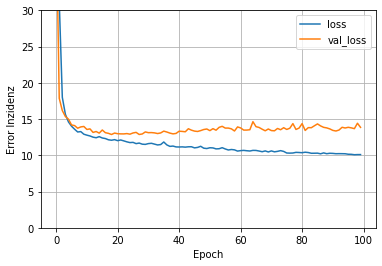

In [48]:
plot_loss(history)

In [49]:
test_results['dnn_MEDmodel'] = dnn_MEDmodel.evaluate(test_features, test_labels, verbose=0)

In [50]:
pd.DataFrame(test_results, index=['Mean absolute error [7TageInzidenzFUTURE]']).T

,Mean absolute error [7TageInzidenzFUTURE]
linear_model,15.117590
linear_model_normalized,12.773072
dnn_model,11.564630
dnn_BIGmodel,12.548034
dnn_MEDmodel,12.309236


In [51]:
def build_and_compile_SMALLmodel(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [52]:
dnn_SMALLmodel = build_and_compile_SMALLmodel(normalizer)
dnn_SMALLmodel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 32)                65        
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 2,210
Trainable params: 2,145
Non-trainable params: 65
_________________________________________________________________


In [53]:
%%time
history = dnn_SMALLmodel.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 16.2 s


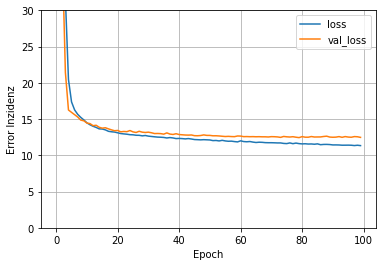

In [54]:
plot_loss(history)

In [55]:
test_results['dnn_SMALLmodel'] = dnn_SMALLmodel.evaluate(test_features, test_labels, verbose=0)

In [56]:
pd.DataFrame(test_results, index=['Mean absolute error [7TageInzidenzFUTURE]']).T

,Mean absolute error [7TageInzidenzFUTURE]
linear_model,15.117590
linear_model_normalized,12.773072
dnn_model,11.564630
dnn_BIGmodel,12.548034
dnn_MEDmodel,12.309236
dnn_SMALLmodel,11.840031


# Neuer Normalizer - DNN

In [57]:
min_trainlabels = train_labels.min()
max_trainlabels = train_labels.max()
train_labels_norm = (train_labels - min_trainlabels) / (max_trainlabels - min_trainlabels)

test_labels_norm = (test_labels - min_trainlabels) / (max_trainlabels - min_trainlabels)

# Selbe Normalisierungen zum Vergleich!

#train_features.head
train_labels_norm

1       0.109180
2       0.096793
4       0.053971
5       0.049016
6       0.028489
          ...   
2293    0.075625
2295    0.137934
2296    0.186397
2298    0.369864
2299    0.565446
Name: 7dInzidenzFUTURE, Length: 1840, dtype: float64

In [58]:
dnn_model_nout = build_and_compile_model(normalizer)
dnn_model_nout.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 32)                65        
_________________________________________________________________
dense_19 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 6,402
Trainable params: 6,337
Non-trainable params: 65
_________________________________________________________________


In [59]:
%%time
history = dnn_model_nout.fit(
    train_features, train_labels_norm,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 14.3 s


In [60]:
def plot_loss_norm(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.3])
  plt.xlabel('Epoch')
  plt.ylabel('Error Inzidenz')
  plt.legend()
  plt.grid(True)

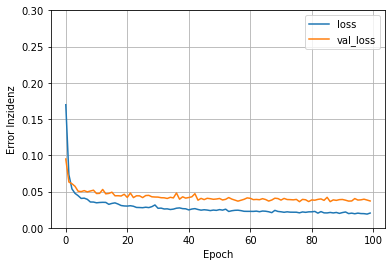

In [61]:
plot_loss_norm(history)

In [62]:
test_results['dnn_model_nout'] = dnn_model_nout.evaluate(test_features, test_labels_norm, verbose=0) *\
                                    (max_trainlabels - min_trainlabels) + min_trainlabels

In [63]:
pd.DataFrame(test_results, index=['Mean absolute error [7TageInzidenzFUTURE]']).T

,Mean absolute error [7TageInzidenzFUTURE]
linear_model,15.117590
linear_model_normalized,12.773072
dnn_model,11.564630
dnn_BIGmodel,12.548034
dnn_MEDmodel,12.309236
dnn_SMALLmodel,11.840031
dnn_model_nout,16.484837


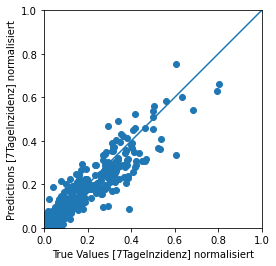

In [64]:
test_predictions_nout = dnn_model_nout.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels_norm, test_predictions_nout)
plt.xlabel('True Values [7TageInzidenz] normalisiert')
plt.ylabel('Predictions [7TageInzidenz] normalisiert')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

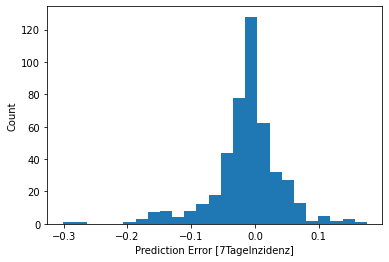

In [65]:
error = test_predictions_nout - test_labels_norm
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [7TageInzidenz]')
_ = plt.ylabel('Count')

## Regularisierung

In [66]:
def build_and_compile_model_reg(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [67]:
dnn_model_reg = build_and_compile_model_reg(normalizer)
dnn_model_reg.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 32)                65        
_________________________________________________________________
dense_22 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 6,402
Trainable params: 6,337
Non-trainable params: 65
_________________________________________________________________


In [68]:
%%time
history = dnn_model_reg.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 15.2 s


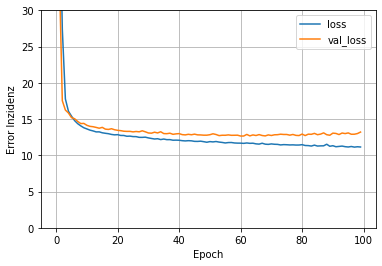

In [69]:
plot_loss(history)

In [70]:
test_results['dnn_model_reg'] = dnn_model_reg.evaluate(test_features, test_labels, verbose=0)

In [71]:
pd.DataFrame(test_results, index=['Mean absolute error [7TageInzidenzFUTURE]']).T

,Mean absolute error [7TageInzidenzFUTURE]
linear_model,15.117590
linear_model_normalized,12.773072
dnn_model,11.564630
dnn_BIGmodel,12.548034
dnn_MEDmodel,12.309236
dnn_SMALLmodel,11.840031
dnn_model_nout,16.484837
dnn_model_reg,12.015050


## Dropout

In [72]:
def build_and_compile_model_drop(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(64, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [73]:
dnn_model_drop = build_and_compile_model_drop(normalizer)
dnn_model_drop.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 32)                65        
_________________________________________________________________
dense_25 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 6,402
Trainable params: 6,337
Non-trainable params: 65
___________________________________________________

In [74]:
%%time
history = dnn_model_drop.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=500)

Wall time: 1min 8s


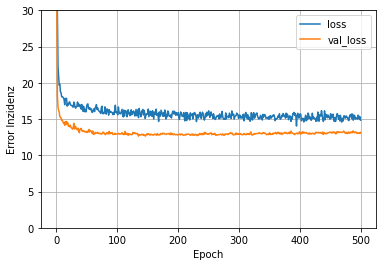

In [75]:
plot_loss(history)

In [76]:
test_results['dnn_model_drop'] = dnn_model_drop.evaluate(test_features, test_labels, verbose=0)

In [77]:
pd.DataFrame(test_results, index=['Mean absolute error [7TageInzidenzFUTURE]']).T

,Mean absolute error [7TageInzidenzFUTURE]
linear_model,15.117590
linear_model_normalized,12.773072
dnn_model,11.564630
dnn_BIGmodel,12.548034
dnn_MEDmodel,12.309236
dnn_SMALLmodel,11.840031
dnn_model_nout,16.484837
dnn_model_reg,12.015050
dnn_model_drop,12.103974


## Regularisierung und Dropout

In [78]:
def build_and_compile_model_Dreg(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.2),
      layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.2),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.0005))
  return model

In [79]:
dnn_model_Dreg = build_and_compile_model_Dreg(normalizer)
dnn_model_Dreg.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 32)                65        
_________________________________________________________________
dense_28 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 65        
Total params: 6,402
Trainable params: 6,337
Non-trainable params: 65
__________________________________________________

In [80]:
%%time
history = dnn_model_Dreg.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=300)

Wall time: 45.6 s


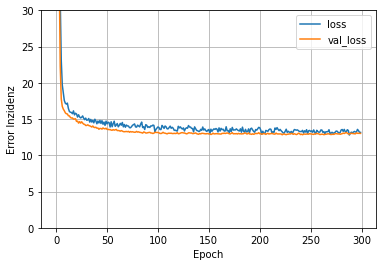

In [81]:
plot_loss(history)

In [82]:
test_results['dnn_model_Dreg'] = dnn_model_Dreg.evaluate(test_features, test_labels, verbose=0)

In [83]:
pd.DataFrame(test_results, index=['Mean absolute error [7TageInzidenzFUTURE]']).T

,Mean absolute error [7TageInzidenzFUTURE]
linear_model,15.117590
linear_model_normalized,12.773072
dnn_model,11.564630
dnn_BIGmodel,12.548034
dnn_MEDmodel,12.309236
dnn_SMALLmodel,11.840031
dnn_model_nout,16.484837
dnn_model_reg,12.015050
dnn_model_drop,12.103974
dnn_model_Dreg,11.972919


## Regularisierung und Dropout - hyperbolic tangent activation function

In [84]:
def build_and_compile_model_Dreg_tanh(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='tanh', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.2),
      layers.Dense(64, activation='tanh', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.2),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [85]:
dnn_model_Dreg_tanh = build_and_compile_model_Dreg_tanh(normalizer)
dnn_model_Dreg_tanh.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 32)                65        
_________________________________________________________________
dense_31 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 65        
Total params: 6,402
Trainable params: 6,337
Non-trainable params: 65
__________________________________________________

In [86]:
%%time
history = dnn_model_Dreg_tanh.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=500)

Wall time: 1min 9s


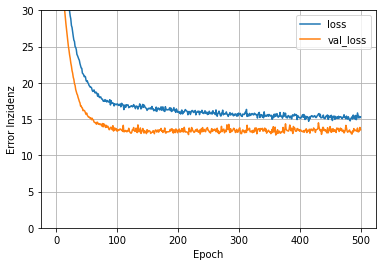

In [87]:
plot_loss(history)

In [88]:
test_results['dnn_model_Dreg_tanh'] = dnn_model_Dreg_tanh.evaluate(test_features, test_labels, verbose=0)

In [89]:
pd.DataFrame(test_results, index=['Mean absolute error [7TageInzidenzFUTURE]']).T

,Mean absolute error [7TageInzidenzFUTURE]
linear_model,15.117590
linear_model_normalized,12.773072
dnn_model,11.564630
dnn_BIGmodel,12.548034
dnn_MEDmodel,12.309236
dnn_SMALLmodel,11.840031
dnn_model_nout,16.484837
dnn_model_reg,12.015050
dnn_model_drop,12.103974
dnn_model_Dreg,11.972919


## Regularisierung und Dropout - sigmoid activation function

In [90]:
def build_and_compile_model_Dreg_sigm(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.2),
      layers.Dense(64, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.2),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [91]:
dnn_model_Dreg_sigm = build_and_compile_model_Dreg_sigm(normalizer)
dnn_model_Dreg_sigm.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 32)                65        
_________________________________________________________________
dense_34 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 65        
Total params: 6,402
Trainable params: 6,337
Non-trainable params: 65
__________________________________________________

In [92]:
%%time
history = dnn_model_Dreg_sigm.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=500)

Wall time: 1min 6s


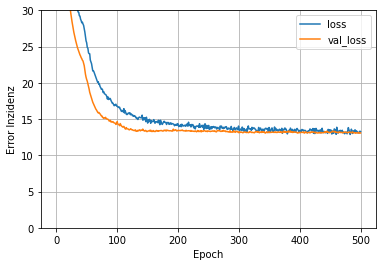

In [93]:
plot_loss(history)

In [94]:
test_results['dnn_model_Dreg_sigm'] = dnn_model_Dreg_sigm.evaluate(test_features, test_labels, verbose=0)

In [95]:
pd.DataFrame(test_results, index=['Mean absolute error [7TageInzidenzFUTURE]']).T

,Mean absolute error [7TageInzidenzFUTURE]
linear_model,15.117590
linear_model_normalized,12.773072
dnn_model,11.564630
dnn_BIGmodel,12.548034
dnn_MEDmodel,12.309236
dnn_SMALLmodel,11.840031
dnn_model_nout,16.484837
dnn_model_reg,12.015050
dnn_model_drop,12.103974
dnn_model_Dreg,11.972919


## Regularisierung und Dropout - Batching

In [96]:
def build_and_compile_model_Dreg_batch(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.2),
      layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.2),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.005))
  return model

In [97]:
dnn_model_Dreg_batch = build_and_compile_model_Dreg_batch(normalizer)
dnn_model_Dreg_batch.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 32)                65        
_________________________________________________________________
dense_37 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 65        
Total params: 6,402
Trainable params: 6,337
Non-trainable params: 65
__________________________________________________

In [98]:
%%time
history = dnn_model_Dreg_batch.fit(
    train_features, train_labels,
    validation_split=0.2,
    batch_size=128,
    verbose=0, epochs=700)

Wall time: 1min 14s


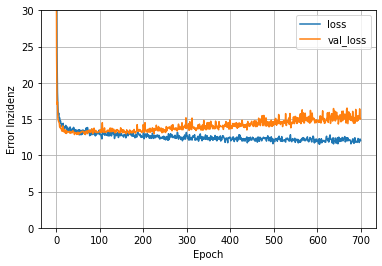

In [99]:
plot_loss(history)

In [100]:
test_results['dnn_model_Dreg_batch'] = dnn_model_Dreg_batch.evaluate(test_features, test_labels, verbose=0)

In [101]:
pd.DataFrame(test_results, index=['Mean absolute error [7TageInzidenzFUTURE]']).T

,Mean absolute error [7TageInzidenzFUTURE]
linear_model,15.117590
linear_model_normalized,12.773072
dnn_model,11.564630
dnn_BIGmodel,12.548034
dnn_MEDmodel,12.309236
dnn_SMALLmodel,11.840031
dnn_model_nout,16.484837
dnn_model_reg,12.015050
dnn_model_drop,12.103974
dnn_model_Dreg,11.972919


## Big Model mit Regularisierung und Dropout

In [102]:
def build_and_compile_BIGmodel_dr(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.6),
      layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.6),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [103]:
dnn_BIGmodel_dr = build_and_compile_BIGmodel_dr(normalizer)
dnn_BIGmodel_dr.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 32)                65        
_________________________________________________________________
dense_40 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 257       
Total params: 74,562
Trainable params: 74,497
Non-trainable params: 65
________________________________________________

In [104]:
%%time
history = dnn_BIGmodel_dr.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=300)

Wall time: 50.4 s


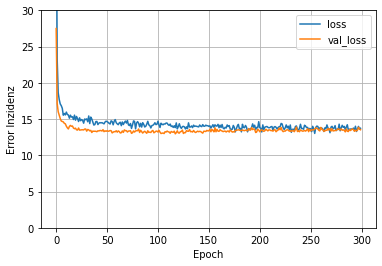

In [105]:
plot_loss(history)

In [106]:
test_results['dnn_BIGmodel_dr'] = dnn_BIGmodel_dr.evaluate(test_features, test_labels, verbose=0)

In [107]:
pd.DataFrame(test_results, index=['Mean absolute error [7TageInzidenzFUTURE]']).T

,Mean absolute error [7TageInzidenzFUTURE]
linear_model,15.117590
linear_model_normalized,12.773072
dnn_model,11.564630
dnn_BIGmodel,12.548034
dnn_MEDmodel,12.309236
dnn_SMALLmodel,11.840031
dnn_model_nout,16.484837
dnn_model_reg,12.015050
dnn_model_drop,12.103974
dnn_model_Dreg,11.972919


## Regularisierung und Dropout - Ohne Activation Functions

In [108]:
def build_and_compile_model_Dreg_withoutAc(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
      layers.Dropout(0.5),
      layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
      layers.Dropout(0.5),
      layers.Dense(64, kernel_regularizer=regularizers.l2(0.005)),
      layers.Dropout(0.5),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [109]:
dnn_model_Dreg_withoutAc = build_and_compile_model_Dreg_withoutAc(normalizer)
dnn_model_Dreg_withoutAc.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 32)                65        
_________________________________________________________________
dense_43 (Dense)             (None, 128)               4224      
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)              

In [110]:
%%time
history = dnn_model_Dreg_withoutAc.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=500)

Wall time: 1min 16s


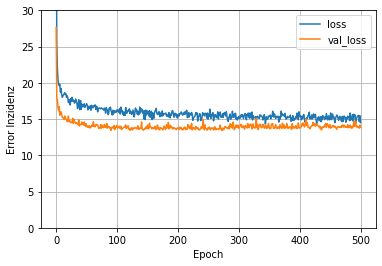

In [111]:
plot_loss(history)

In [112]:
test_results['dnn_model_Dreg_withoutAc'] = dnn_model_Dreg_withoutAc.evaluate(test_features, test_labels, verbose=0)

In [113]:
pd.DataFrame(test_results, index=['Mean absolute error [7TageInzidenzFUTURE]']).T

,Mean absolute error [7TageInzidenzFUTURE]
linear_model,15.117590
linear_model_normalized,12.773072
dnn_model,11.564630
dnn_BIGmodel,12.548034
dnn_MEDmodel,12.309236
dnn_SMALLmodel,11.840031
dnn_model_nout,16.484837
dnn_model_reg,12.015050
dnn_model_drop,12.103974
dnn_model_Dreg,11.972919
